# Control Systems 2, Coding Exercise 02: Jupyter Notebook on Discretization and Emulation

This Notebook is designed to teach you the effects of Discretization on continuous System with a focus on showing how different methods affect stability and how the sampling time can affect your System. This Notebook contains 3 Exercises and a Case Study that mostly serves as an example. We wish you a nice time when solving this Notebook.
Authors:
- Paolo Petri; ppetri@ethz.ch
- Juncheng Fu; juncfu@ethz.ch
- Niclas Scheuer; nscheuer@ethz.ch
- Roy Werder; werderr@ethz.ch

# Setup:


## Installing the required packages:
The following piece of code will check wether the packages required for this Jupyter Notebook are installed. If they aren't yet installed it will automatically install them.

In [9]:
%pip install numpy control scipy matplotlib

Note: you may need to restart the kernel to use updated packages.


## Import packages:
The following piece of code will import the packages that will be used in the code. Take note of the chosen shortcuts. If you have no experience with the [NumPy](https://numpy.org/) library, read the documentation and do some tutorials. It is very important for matrix operations in Python.

In [10]:
from typing import Optional, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy import signal as sig
from scipy.signal import butter, lfilter

## Plotting functions:
Define the plotting functions that will be used in the exercises. If you are interested, have a look.

In [11]:
def plot_helpers() -> None:
  """
  This function sets up the plot with appropriate labels and legend.
  
  Parameters: 
   - None

  Returns: 
   - None
  """
  plt.xlabel('Time')
  plt.ylabel('Output')
  plt.legend()


def plot_step_responses(t_stable_cont: np.array, y_stable_cont: np.array,
                        t_stable_eulerf: np.array, y_stable_eulerf: np.array,
                        t_stable_eulerb: np.array, y_stable_eulerb: np.array,
                        t_stable_tust: np.array, y_stable_tust: np.array,
                        t_stable_zoh: np.array, y_stable_zoh: np.array) -> None:
    """
    This function plots the step responses of a systems using different discretization methods. Plotted: Continuous, Forward Euler, Backward Euler, Tustin, and Zero Order Hold.

    Parameters:
    - ``t_stable_cont`` (np.array): Time array for the continuous system.
    - ``y_stable_cont`` (np.array): Output array for the continuous system.
    - ``t_stable_eulerf`` (np.array): Time array for the Forward Euler system.
    - ``y_stable_eulerf`` (np.array): Output array for the Forward Euler system.
    - ``t_stable_eulerb`` (np.array): Time array for the Backward Euler system.
    - ``y_stable_eulerb`` (np.array): Output array for the Backward Euler system.
    - ``t_stable_tust`` (np.array): Time array for the Tustin system.
    - ``y_stable_tust`` (np.array): Output array for the Tustin system.
    - ``t_stable_zoh`` (np.array): Time array for the Zero Order Hold system.
    - ``y_stable_zoh`` (np.array): Output array for the Zero Order Hold system.

    Returns:
    - None
    """
    
    plt.figure(figsize=[24, 16])
    plt.subplot(3, 2, 1)
    plt.plot(t_stable_cont, y_stable_cont, label='Continuous System')
    plt.plot(t_stable_eulerf, y_stable_eulerf, label='Forward Euler')
    plt.plot(t_stable_eulerb, y_stable_eulerb, label='Backward Euler')
    plt.plot(t_stable_tust, y_stable_tust, label='Tustin')
    plt.plot(t_stable_zoh, y_stable_zoh, label='Zero Order Hold')

    # Adding labels and title to the plot.
    
    plt.title('Step Response Combined')
    plot_helpers()
    

    plt.subplot(3, 2, 2)
    plt.plot(t_stable_cont, y_stable_cont, label='Continuous System', color = 'C0')

    # Adding labels and title to the plot.
    plt.title('Step Response Continuous')
    plot_helpers()


    plt.subplot(3, 2, 3)
    plt.plot(t_stable_eulerf, y_stable_eulerf, label='Forward Euler', color = 'C1')

    # Adding labels and title to the plot.
    plt.title('Step Response Forward Euler')
    plot_helpers()


    plt.subplot(3, 2, 4)
    plt.plot(t_stable_eulerb, y_stable_eulerb, label='Backward Euler', color = 'C2')

    # Adding labels and title to the plot.
    plt.title('Step Response Backward Euler')
    plot_helpers()


    plt.subplot(3, 2, 5)
    plt.plot(t_stable_tust, y_stable_tust, label='Tustin', color = 'C3')

    # Adding labels and title to the plot.
    plt.title('Step Response Tustin')
    plot_helpers()


    plt.subplot(3, 2, 6)
    plt.plot(t_stable_zoh, y_stable_zoh, label='Zero Order Hold', color = 'C4')

    # Adding labels and title to the plot.
    plt.title('Step Response Zero Order Hold')
    plot_helpers()

    return None
    
    
# Visualize the Noise signal in Morse-Transmission
def plot_noise_signal(t_cont: np.array, rand_noise: np.array,
            t_cont_start: int, t_cont_end: int) -> None:
  """
  Plot the continuous noise signal.
  
  Parameters:
   - ``t_cont`` (np.array): Array of time values for the continuous signal.
   - ``rand_noise`` (np.array): Array of amplitude values for the continuous noise signal.
   - ``t_cont_start`` (int): Start time for the x-axis.
   - ``t_cont_end`` (int): End time for the x-axis.

  Returns:
   - None
  """
  
  plt.figure(figsize=(5, 3))
  plt.title("(Continuous) Noise")
  plt.axhline(y=0, color='g', linestyle='-')
  plt.plot(t_cont, rand_noise)
  plt.xticks(np.arange(t_cont_start, t_cont_end))
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()
    
  return None
    
    
    
    
def plot_disc_stepresponses(t_cont: np.array, y_cont: np.array,
              t_eulerf: np.array, y_eulerf: np.array,
              t_eulerb: np.array, y_eulerb: np.array,
              t_tust: np.array, y_tust: np.array,
              t_zoh: np.array, y_zoh: np.array, Ts: float) -> None:
  """
  Plots the step responses of a discrete system along with the continuous system.
  
  Parameters:
   - ``t_cont`` (np.array): Time array for the continuous system.
   - ``y_cont`` (np.array): Output array for the continuous system.
   - ``t_eulerf`` (np.array): Time array for the forward Euler method.
   - ``y_eulerf`` (np.array): Output array for the forward Euler method.
   - ``t_eulerb`` (np.array): Time array for the backward Euler method.
   - ``y_eulerb`` (np.array): Output array for the backward Euler method.
   - ``t_tust`` (np.array): Time array for the Tustin method.
   - ``y_tust`` (np.array): Output array for the Tustin method.
   - ``t_zoh`` (np.array): Time array for the Zero Order Hold method.
   - ``y_zoh`` (np.array): Output array for the Zero Order Hold method.
   - ``Ts`` (float): Sampling time of the discrete system.
  
  Returns:
   - None
  """
  plt.figure(figsize=(10, 6))
  
  # Inserting initial values for step response plotting
  t_eulerf = np.insert(np.squeeze(t_eulerf)+Ts,0,0)
  y_eulerf = np.insert(np.squeeze(y_eulerf), 0, 0)
  t_eulerb = np.insert(np.squeeze(t_eulerb)+Ts,0,0)
  y_eulerb = np.insert(np.squeeze(y_eulerb), 0, 0)
  t_tust = np.insert(np.squeeze(t_tust)+Ts,0,0)
  y_tust = np.insert(np.squeeze(y_tust), 0, 0)
  t_zoh = np.insert(np.squeeze(t_zoh)+Ts,0,0)
  y_zoh = np.insert(np.squeeze(y_zoh), 0, 0)
  
  # Plotting the step responses
  plt.plot(t_cont, y_cont, label='Continuous System')
  plt.step(t_eulerf, y_eulerf, label='Forward Euler')
  plt.step(t_eulerb, y_eulerb, label='Backward Euler')
  plt.step(t_tust, y_tust, label='Tustin')
  plt.step(t_zoh, y_zoh, label='Zero Order Hold')
  plt.title('Discrete Step Response')
  plt.xlabel('Time (s)')
  plt.ylabel('Output')
  plt.legend()
  plt.show()

  return None


## Duckiebot System Matrices
This piece of Code defines the dynamics of the Duckiebot which shall be used as an example in question 1.

In [12]:
# Save the system matrices for later use.
A = np.array([[0, 0.1], [0, 0]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
D = np.array([[0]])

-------------------
# Exercise 1

## Exercise 1a:

Now we'll see how the different discretization schemes affect the step response of the duckiebot controller. 
Hint:
- You may use `sig.lti(...)` to create a continuous time system
- You can discretize the system using `sig.cont2discrete((...), dt=..., method='...')`
- If you are stuck, have a look at the [Scipy Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cont2discrete.html)
- You can produce the values for a discretized step response using `sig.dstep`
- To better visualize your System we advise you to terminate all functions at the same time-value


In [13]:
def continuous_step_response(A: np.array, B: np.array, C:np.array, D:np.array) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the continuous step response.

    # return the time and output vectors (as np.ndarray) of the step response.
    return [t, y]

def discrete_step_response_euler_forward(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the forward Euler discretization.

    # return the time and output vectors (as np.ndarray) of the step response.
    return [t, y]

def discrete_step_response_euler_backward(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the backward Euler discretization.

    # return the time and output vectors (as np.ndarray) of the step response.
    return [t, y]

def discrete_step_response_tustin(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the Tustin discretization.

    # return the time and output vectors (as np.ndarray) of the step response.
    return [t, y]

def discrete_step_response_zoh(A: np.array, B: np.array, C:np.array, D:np.array, dt: float) -> Tuple[np.array, np.array]:
    
    #TODO: Implement the discrete step response using the Zero Order Hold discretization.

    # return the time and output vectors (as np.ndarray) of the step response.
    return [t, y]

## Solution Exercise 1a:

In [14]:
def cont_solution (A: np.array, B: np.array, C:np.array, D:np.array) -> Tuple[np.array, np.array]:
    """
    Calculates the step response of a continuous-time linear time-invariant system.
    
    Parameters:
     - ``A`` (np.array): State matrix of the system.
     - ``B`` (np.array): Input matrix of the system.
     - ``C`` (np.array): Output matrix of the system.
     - ``D`` (np.array): Direct transmission matrix of the system.
    
    Returns:
     - Tuple[np.array, np.array]: A tuple containing the time values and the corresponding output values of the step response.
    """
    
    sysc = sig.lti(A, B, C, D)

    t_cont, y_cont = sysc.step(T = np.linspace(0, 25, 1000))
    
    return [t_cont, y_cont]

def disc_solution(A: np.array, B: np.array, C: np.array, D: np.array, Ts: float) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array, np.array, np.array]:
    """
    Calculates the discrete-time step response using different methods.

    Parameters:
     - ``A`` (np.array): State matrix of the continuous-time system.
     - ``B`` (np.array): Input matrix of the continuous-time system.
     - ``C`` (np.array): Output matrix of the continuous-time system.
     - ``D`` (np.array): Feedthrough matrix of the continuous-time system.
     - ``Ts`` (float): Sampling time.

    Returns:
    Tuple[np.array, np.array, np.array, np.array, np.array, np.array, np.array, np.array]: A tuple containing the time and output arrays for each method:
        - ``t_eulerf``: Time array for the forward Euler method.
        - ``y_eulerf``: Output array for the forward Euler method.
        - ``t_eulerb``: Time array for the backward difference method.
        - ``y_eulerb``: Output array for the backward difference method.
        - ``t_tust``: Time array for the Tustin method.
        - ``y_tust``: Output array for the Tustin method.
        - ``t_zoh``: Time array for the zero-order hold method.
        - ``y_zoh``: Output array for the zero-order hold method.
    """
        
    sysd_eulerf = sig.cont2discrete((A, B, C, D), Ts, method='euler')
    t_eulerf, y_eulerf = sig.dstep(sysd_eulerf, t=np.arange(0, 25, Ts))

    sysd_eulerb = sig.cont2discrete((A, B, C, D), Ts, method='backward_diff')
    t_eulerb, y_eulerb = sig.dstep(sysd_eulerb, t=np.arange(0, 25, Ts))

    sysd_tust = sig.cont2discrete((A, B, C, D), Ts, method='bilinear')
    t_tust, y_tust = sig.dstep(sysd_tust, t=np.arange(0, 25, Ts))

    sysd_zoh = sig.cont2discrete((A, B, C, D), Ts, method='zoh')
    t_zoh, y_zoh = sig.dstep(sysd_zoh, t=np.arange(0, 25, Ts))
    
    return [t_eulerf, y_eulerf, t_eulerb, y_eulerb, t_tust, y_tust, t_zoh, y_zoh]


## Exercise 1a: Test your code:
Set the Use_User_Implementation variable to True if you want to test your own implementation. However, it is currently set to False to prevent an error from occuring.

In [15]:
def test_user_implementations(): 
    """
    Test the user's implementation of the step response functions.

    This function tests the user's implementation of the continuous and discrete step response functions.
    It calls the continuous_step_response and various discrete_step_response functions with different methods,
    and plots the step responses using the plot_disc_stepresponses function.

    Parameters:
     - None

    Returns:
     - None
    """

    # Define the sampling time. Feel free to play around with this value.
    Ts = 2 

    # Test the user's implementation. 
    t_cont, y_cont = continuous_step_response(A, B, C, D)
    t_eulerf, y_eulerf = discrete_step_response_euler_forward(A, B, C, D, Ts)
    t_eulerb, y_eulerb = discrete_step_response_euler_backward(A, B, C, D, Ts)
    t_tust, y_tust = discrete_step_response_tustin(A, B, C, D, Ts)
    t_zoh, y_zoh = discrete_step_response_zoh(A, B, C, D, Ts)

    # Plot the step responses.
    plot_disc_stepresponses(t_cont, y_cont, t_eulerf, y_eulerf, t_eulerb, y_eulerb, t_tust, y_tust, t_zoh, y_zoh, Ts)

    return None
    

Use_User_Implementations = False
if Use_User_Implementations:
    test_user_implementations()
else:
    print("The user's implementations are not being used. Set the Use_User_Implementations variable to True to use the user's implementations.")

The user's implementations are not being used. Set the Use_User_Implementations variable to True to use the user's implementations.


## Solution Plots Exercise 1a:

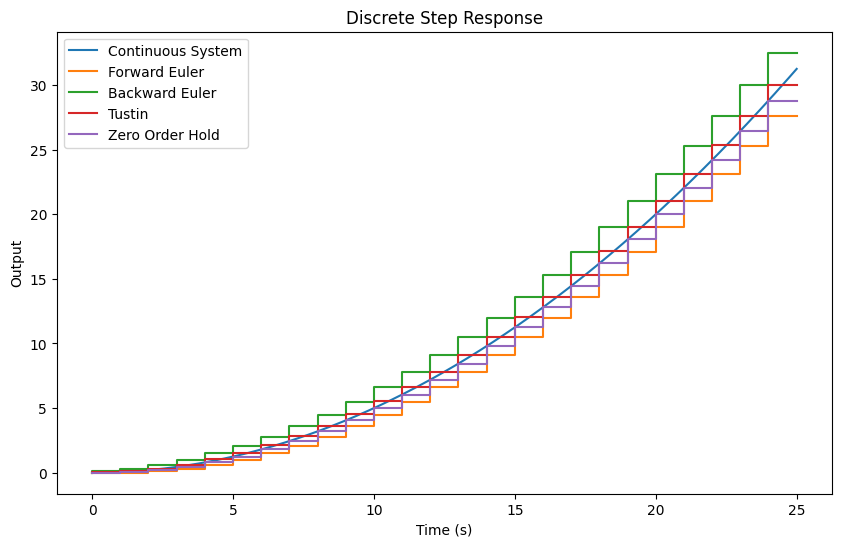

In [16]:
Ts=1

# Call for the solutions and store them.
[t_cont_sol, y_cont_sol] = cont_solution(A, B, C, D)
[t_eulerf_sol, y_eulerf_sol, t_eulerb_sol, y_eulerb_sol, t_tust_sol, y_tust_sol, t_zoh_sol, y_zoh_sol] = disc_solution(A, B, C, D, Ts)

# Plot the step responses.
plot_disc_stepresponses(t_cont_sol, y_cont_sol, t_eulerf_sol, y_eulerf_sol, t_eulerb_sol, y_eulerb_sol, t_tust_sol, y_tust_sol, t_zoh_sol, y_zoh_sol, Ts)

##
Interpret the result (Hint: To see the differences between the different discretizations more clearly, increase `Ts` (more on this in the second part)):

- Which discretization method is closest to the continuous system?
- Why do all the plots diverge?
- Can you show the basic idea behind Zero-Order-Hold in this graph?


-----
Since all of the above step responses diverge, we are unable to demonstrate that the different discretizations can make a stable system unstable. To remedy this we place poles at desired locations via the [Ackermann Formula](https://en.wikipedia.org/wiki/Ackermann%27s_formula#Ackermann's_formula).

In [17]:
def feedforward_kr(A: np.array, B: np.array, C: np.array, K: np.array) -> np.array:
    """
    Calculates the feedforward gain (kr) for a given system.

    Parameters:
     - ``A`` (np.array): The state matrix of the system.
     - ``B`` (np.array): The input matrix of the system.
     - ``C`` (np.array): The output matrix of the system.
     - ``K`` (np.array): The feedback gain matrix of the system.

    Returns:
     - ``kr`` (np.array): The feedforward gain (kr) of the system.
    """

    ABK = A - B @ K
    ABK_inv = np.linalg.inv(ABK)
    den = C @ ABK_inv @ B
    kr = - 1/den

    return kr


def acker(A: np.array, B: np.array, poles: List[float]) -> np.array:
    """
    Calculates the state feedback gain matrix K using the Ackermann's formula.

    Parameters:
     - ``A`` (np.array): State matrix of the system.
     - ``B`` (np.array): Input matrix of the system.
     - ``poles`` (List[float]): List of desired closed-loop poles.

    Returns:
     - ``K`` (np.array): State feedback gain matrix K.
    """

    AB = A @ B
    R = np.concatenate((B, AB), axis=1)
    R_inv = np.linalg.inv(R)
    gamma = np.array([[0, 1]]) @ R_inv

    p_1 = poles[0]*(-1)
    p_2 = poles[1]*(-1)
    ab = p_1 + p_2
    b = p_1*p_2
    p_cl = A @ A + ab*A + b*np.identity(2)

    K = gamma @ p_cl

    return K


def place_poles_Ackermann(A: np.array, B: np.array, C: np.array,
                          D: float, poles: List) -> np.array:
    """
    Computes the controller gains and closed loop system dynamics using the Ackermann method
    to place the poles of the system at desired locations.
    
    Parameters:
     - ``A`` (np.array): State matrix of the system.
     - ``B`` (np.array): Input matrix of the system.
     - ``C`` (np.array): Output matrix of the system.
     - ``D`` (float): Direct transmission matrix of the system.
     - ``poles`` (List): List of desired pole locations.
        
    Returns:
     - ``clsys`` (np.array): Updated system dynamics using new poles and feedforward gain.
    """
    
    K=ct.acker(A, B, poles)
    
    # Create a new system representing the closed loop response.
    clsys = ct.StateSpace(A - B @ K, B, C, D)

    # Compute the feedforward gain.
    kr = feedforward_kr(A, B, C, K)
    
    # Scale the input by the feedforward gain.
    clsys *= kr

    # Return gains and closed loop system dynamics.
    return clsys

## Exercise 1b:

In this exercise you will:
- Try to make all the discretizations stable via changing the desired poles `p_des`.
- Try to make all the discretizations stable via changing the `Ts`.

Notes: 
- The function as is will not run. To make it run, change the Use_User_Implementation variable to True.
- To start off with, not all the step responses are stable.
- We will reuse the functions defined in 1a. If you couldn't solve them, use `cont_solution` and `disc_solution` where indicated.

In [18]:
def test_user_implementations():
    """
    Test the user's implementations of the closed-loop system dynamics and step response calculations.

    This function computes the closed-loop system dynamics using Ackermann's formula and
    calculates the step response of both the continuous and discrete closed-loop systems
    using different discretization schemes. It then plots the step responses.

    Parameters:
     - None

    Returns:
     - None
    """
    
    # Choose your desired poles. Feel free to play around with them.
    p_des = [-0.5+3j, -0.5-3j] 

    # Define the sampling time. Feel free to play around with this value.
    Ts=0.25

    # Compute the closed loop system dynamics using Ackermann's formula.
    clsys_p = place_poles_Ackermann(A=A, B=B, C=C, D=0,
                                        poles=p_des)
    t_p, y_p = ct.step_response(clsys_p, input=0, output=0)

    # Define the system matrices and sampling time
    A_stable = clsys_p.A
    B_stable = clsys_p.B
    C_stable = clsys_p.C
    D_stable = clsys_p.D



    # Compute the step response of the continuous closed loop system. 
    # If you couldn't solve the previous exercise, you can use the solution. For that replace the function call with the following:
    # [t_stable_cont, y_stable_cont] = cont_solution(A_stable, B_stable, C_stable, D_stable)
    t_stable_cont, y_stable_cont = continuous_step_response(A_stable, B_stable, C_stable, D_stable)



    # Compute the step response of the discrete closed loop system using the different discretization schemes. 
    # If you couldn't solve the previous exercise, you can use the solution. For that replace the function call with the following:
    # [t_stable_eulerf, y_stable_eulerf, t_stable_eulerb, y_stable_eulerb, t_stable_tust, y_stable_tust, t_stable_zoh, y_stable_zoh] = disc_solution(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_eulerf, y_stable_eulerf = discrete_step_response_euler_forward(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_eulerb, y_stable_eulerb = discrete_step_response_euler_backward(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_tust, y_stable_tust = discrete_step_response_tustin(A_stable, B_stable, C_stable, D_stable, Ts)
    t_stable_zoh, y_stable_zoh = discrete_step_response_zoh(A_stable, B_stable, C_stable, D_stable, Ts)



    # Package the results for plotting.
    values_to_plot = [t_stable_cont, y_stable_cont,
                    t_stable_eulerf, y_stable_eulerf,
                    t_stable_eulerb, y_stable_eulerb,
                    t_stable_tust, y_stable_tust,
                    t_stable_zoh, y_stable_zoh]

    # Plot the step responses.
    plot_step_responses(*values_to_plot)

    return None
    
    
    
Use_User_Implementations = False
if Use_User_Implementations:
    test_user_implementations()
else:
    print("The user's implementations are not being used. Set the Use_User_Implementations variable to True to use the user's implementations.")

The user's implementations are not being used. Set the Use_User_Implementations variable to True to use the user's implementations.


Interpret your findings with respect to the following questions:

- Which of these graphs follows the contiunous system the closest?
- Does that change when you decrease or increase Ts?
- Why does that happen?
- For the default poles, what is the limit for Ts such that no discretization diverges?
- What happens when the poles are outside the unit circle? What happens when they are on it?

----------------
# Introduction to the second part of the Notebook

In the realm of digital control and signal processing, the choice of time step (dt) for system discretization is a critical decision that can significantly affect system performance and stability. Different discretization methods may react uniquely to changes in the time step, leading to variations in the system's behavior and response to inputs. This exercise is designed to delve into this aspect by systematically analyzing how varying the time step influences the performance of different discretization methods applied to a given system.

The primary goal is to uncover the relationship between the time step size and the resulting system stability and performance. By varying the time step and observing the corresponding step responses, we aim to identify the largest time step at which the system remains stable across all considered discretization methods. This exercise not only enhances our understanding of discretization effects but also guides the optimal selection of time steps in practical applications, ensuring both system stability and computational efficiency.

Through a combination of simulation and analysis, this exercise will equip participants with the insights needed to make informed decisions regarding time step selection in the discretization process, ultimately leading to more robust and reliable digital control systems.

## System Library

In here you will find different systems that show the advantages and disadvantages for the three discretization methods.

In [19]:
def create_system1() -> ct.StateSpace:
    A = np.array([[-1, -1],
                  [2, -0.25]])
    B = np.array([[1],
                  [1]])
    C = np.array([[1, 1]])
    D = np.array([[0]])
    return ct.StateSpace(A, B, C, D)

# Feel free to define your own system here.
def create_system2() -> ct.StateSpace:
    A = np.array([[0, 0],
                  [0, 0]])
    B = np.array([[0],
                  [0]])
    C = np.array([[0, 0]])
    D = np.array([[0]])
    return ct.StateSpace(A, B, C, D)

# Create the systems.
system1 = create_system1()
system2 = create_system2()

-------
## Descretization Methods

You can later return here if you would like to understand the code in depth. These functions define the manual way of discretization as compared to the inbuilt functions seen in exercise 1.

### Euler Forward Method

In [20]:
def euler_forward(system, dt) -> ct.StateSpace:
    """
    Discretize a continuous-time system using the Euler forward method.

    Parameters:
     - ``system`` (ct.StateSpace): State-space system (instance of ct.StateSpace).
     - ``dt`` (float): Time step for discretization.

    Returns:
     - StateSpace(Ad, Bd, Cd, Dd): Discretized state-space matrices.
    """
    A, B, C, D = system.A, system.B, system.C, system.D
    I = np.eye(A.shape[0])
    Ad = I + dt * A
    Bd = dt * B
    Cd = C
    Dd = D
    return ct.StateSpace(Ad, Bd, Cd, Dd)

### Euler Backwards Method

In [21]:
def euler_backward(system, dt) -> ct.StateSpace:
    """
    Discretize a continuous-time system using the Euler backward method.

    Parameters:
     - ``system`` (ct.StateSpace): State-space system (instance of ct.StateSpace).
     - ``dt`` (float): Time step for discretization.

    Returns:
     -   StateSpace(Ad, Bd, Cd, Dd): Discretized state-space matrices.
    """
    A, B, C, D = system.A, system.B, system.C, system.D
    I = np.eye(A.shape[0])
    Ad = np.linalg.inv(I - dt * A)
    Bd = np.dot(Ad, dt * B)
    Cd = C
    Dd = D
    return ct.StateSpace(Ad, Bd, Cd, Dd)

### Tustin's Method

In [22]:
def tustin_method(system, dt) -> ct.StateSpace:
    """
    Discretize a continuous-time system using Tustin's method (bilinear transformation).
    
    Parameters:
     - ``system`` (ct.StateSpace): State-space system (instance of ct.StateSpace).
     - ``dt`` (float): Time step for discretization.
    
    Returns:
     - StateSpace(Ad, Bd, Cd, Dd): Discretized state-space matrices.
    """
    A, B, C, D = system.A, system.B, system.C, system.D
    I = np.eye(A.shape[0])
    pre_matrix = np.linalg.inv(I - (dt / 2) * A)
    Ad = np.dot(pre_matrix, I + (dt / 2) * A)
    Bd = np.dot(pre_matrix, dt * B)
    Cd = C
    Dd = D
    return ct.StateSpace(Ad, Bd, Cd, Dd)

## Functions

You are invited to read through them if you are interested how the code works.

In [23]:
def discretize(system: ct.StateSpace, dt: float) -> Tuple[ct.StateSpace, ct.StateSpace, ct.StateSpace]:
    """
    Discretizes a continuous-time system into discrete-time systems using three methods: 
    Euler Forward, Euler Backward, and Tustin's method.

    Parameters:
     - ``system`` (ct.StateSpace): A continuous-time system represented as a ct.StateSpace object.
     - ``dt`` (float): Time step for discretization.

    Returns:
     - Tuple[ct.StateSpace, ct.StateSpace, ct.StateSpace]: A tuple of discretized systems (dt_forward, dt_backward, dt_tustin), each representing 
              the input system discretized using Euler Forward, Euler Backward, and Tustin's method, respectively.
    """
    # Discretize using each method
    dt_forward = euler_forward(system, dt)
    dt_backward = euler_backward(system, dt)
    dt_tustin = tustin_method(system, dt)
    
    return dt_forward, dt_backward, dt_tustin

In [24]:
def plot_eigenvalues(system, method_name):
        """
        Plots the eigenvalues of the discretized system's A matrix on the complex plane.

        Parameters:
         - ``system`` (ct.StateSpace): A discrete-time system represented as a ct.StateSpace object, 
                                                          whose eigenvalues are to be plotted.
         - ``method_name`` (str): The name of the discretization method used for this system. 
                                                  This name is used as a label in the plot.

        Returns:
         - None

        The function calculates the eigenvalues of the system's A matrix, prints them,
        and plots them on the complex plane. Each set of eigenvalues is labeled according 
        to the discretization method used.
        """
        Ad = system.A
        eigenvalues = np.linalg.eigvals(Ad)
        print("Eigenvalues using " + method_name)
        print(eigenvalues)
        print("Magnitude")
        print(np.linalg.norm(eigenvalues[0]))
        print("\n")

        plt.scatter(eigenvalues.real, eigenvalues.imag, label=method_name)

        return None

In [25]:
def plot_table(dt_forward, dt_backward, dt_tustin):
    """
    Plots the eigenvalues of three discretized systems on the complex plane to compare their stability.

    Parameters:
     - ``dt_forward`` (ct.StateSpace): Discretized system using the Euler Forward method (StateSpace object).
     - ``dt_backward`` (ct.StateSpace): Discretized system using the Euler Backward method (StateSpace object).
     - ``dt_tustin`` (ct.StateSpace): Discretized system using Tustin's method (StateSpace object).

    This function visualizes the eigenvalues of the given discretized systems on the complex plane.
    It helps in comparing the stability characteristics of the systems discretized using different methods.
    The function plots each set of eigenvalues with a different label corresponding to the discretization method.
    It also includes a unit circle for reference, aiding in the assessment of stability (eigenvalues inside the 
    unit circle indicate stability in discrete-time systems).

    Returns:
     - None
    """
    plt.figure(figsize=(8, 6))
    
    plot_eigenvalues(dt_forward, 'Euler Forward')
    plot_eigenvalues(dt_backward, 'Euler Backward')
    plot_eigenvalues(dt_tustin, 'Tustin')
    
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Eigenvalues of Discretized Systems')
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
    plt.grid(True)

    # adding unit circle for visualization
    theta = np.linspace(0, 2 * np.pi, 100)  # 100 points between 0 and 2*pi
    x = np.cos(theta)  # x coordinates on the circle
    y = np.sin(theta)  # y coordinates on the circle
    plt.plot(x, y, linestyle='--', color='grey')

    plt.show()

    return None

In [26]:
def simulate_step_response(system, dt, label, n=100):
    """
    Simulates and plots the step response of a discretized system.

    Parameters:
     - ``system`` (ct.StateSpace): A StateSpace object representing the discretized system.
     - ``dt`` (float): The sampling time step used for the discretization.
     - ``label`` (str): A string label to identify the step response in the plot.
     - ``n`` (int): The number of time steps to simulate (default is 100).

    This function calculates the step response of a given discretized system using the provided time step (dt) over 'n' time steps. 
    It then plots the response using matplotlib, labeling the plot with the given label for easy identification. 
    The step response is visualized using a step plot, which shows how the system's output evolves over time in response to a unit step input.

    Returns:
     - None
    """
    lti = sig.dlti(system.A, system.B, system.C, system.D, dt=dt)
    t, y = sig.dstep(lti, n=n)
    plt.step(t, np.squeeze(y), label=label)

    return None

-------
## Exercise: Performance Analysis under Varying Time Steps

Objective: Evaluate how the choice of time step affects the performance of each discretization method.

Tasks:

	1. Take a look at the System Library above and check system1 which we are discretizing. Also, check the poles on the complex plane as well as the step response.
	2. Vary the time step (e.g., dt = 0.75, 0.5) in the console. Plot the responses for different time steps and compare how each method reacts to changes in the time step.
	3. Find the biggest time step that makes the system become stable for all approximation methods.
	4. Why does it make sense that the system becomes stable for all approximation methods with a smaller time step?

### Console

This is where you change your system (eg. system1, system2) and vary the step time.

In [27]:
# Time step for discretization.
dt =  1.0

# Calls the chosen system.
test = system1 # system1 or system2

### Discrete Poles on the Complex Plane

Below you will all the poles printed as well plotted on the complex plane. Remember that in descrete time a system is stable when the magnetude of all the eigenvalues (poles) is smaller than one.

Eigenvalues of continous system:
[-0.625+1.36358901j -0.625-1.36358901j]


Eigenvalues using Euler Forward
[0.375+1.36358901j 0.375-1.36358901j]
Magnitude
1.4142135623730951


Eigenvalues using Euler Backward
[0.36111111+0.30301978j 0.36111111-0.30301978j]
Magnitude
0.47140452079103157


Eigenvalues using Tustin
[0.2+0.62335498j 0.2-0.62335498j]
Magnitude
0.6546536707079771




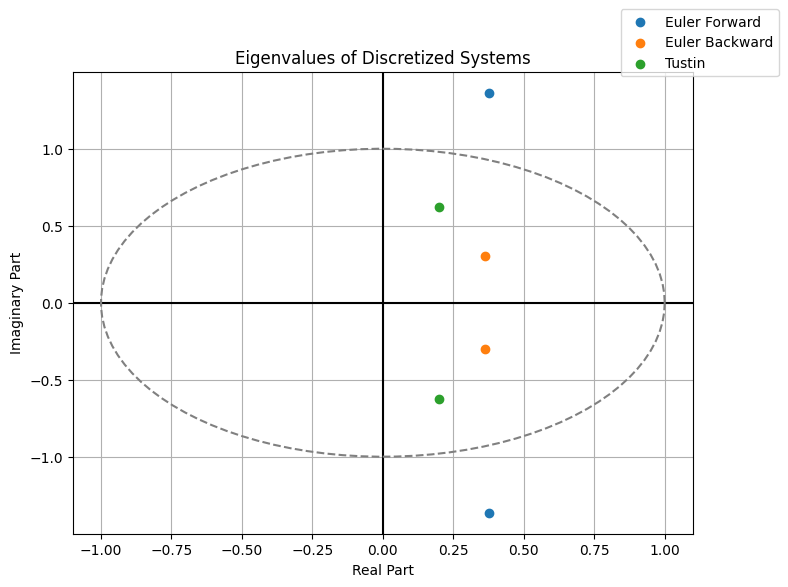

In [28]:
# eigenvalues in continuous time for comparison.
print("Eigenvalues of continous system:")
print(np.linalg.eigvals(test.A))
print("\n")


dt_forward, dt_backward, dt_tustin = discretize(test, dt)
plot_table(dt_forward, dt_backward, dt_tustin)

### Insights from the Complex Plane

By employing Euler forward, Euler backward, and Tustin’s methods to discretize the system for a given time step (dt = 1 second), we could observe the distinct impacts these methods have on system stability.

The eigenvalues of the discretized systems were calculated and visually plotted on the complex plane. This visualization, facilitated by the unit circle on the plot, was instrumental in determining the stability of the systems. Systems with eigenvalues lying inside the unit circle are deemed stable in the discrete-time domain.

A key observation from the complex plane is the critical role of the discretization method in system stability. Notably, the Euler Forward method often presents a risk of making a stable continuous-time system unstable in the discrete-time domain. This is particularly true for systems with eigenvalues close to the stability boundary. Therefore, careful consideration is required when selecting this method, underscoring the need for a rigorous stability check post-discretization.

This analysis highlights the importance of not only choosing the appropriate discretization method but also thoroughly checking the resulting system's stability, especially when employing the Euler Forward method. Such diligence is crucial in ensuring the reliability and accuracy of digital control systems, particularly in applications where precise control and stability are paramount.

### Simulating the Step Response of the Discretized Systems

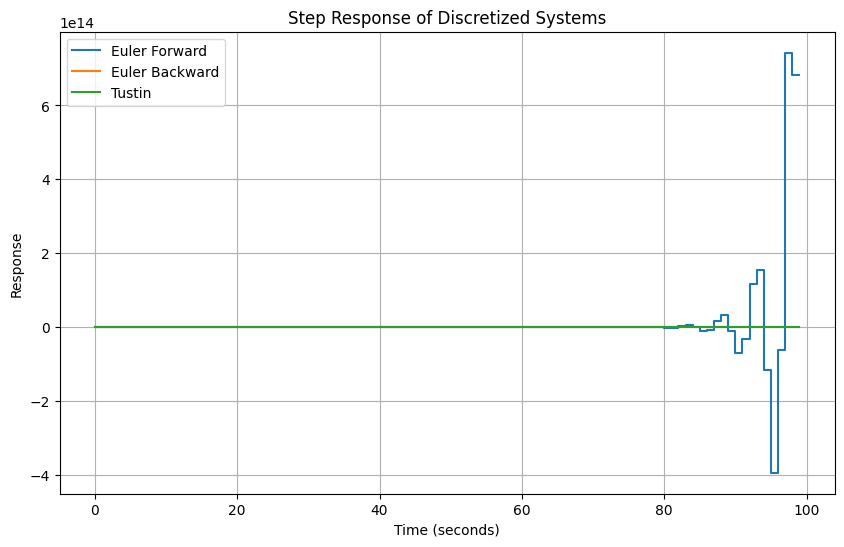

In [29]:
plt.figure(figsize=(10, 6))

# Simulate step response for each method
simulate_step_response(dt_forward, dt, label='Euler Forward')
simulate_step_response(dt_backward, dt, label='Euler Backward')
simulate_step_response(dt_tustin, dt, label='Tustin')

plt.xlabel('Time (seconds)')
plt.ylabel('Response')
plt.title('Step Response of Discretized Systems')
plt.legend()
plt.grid(True)
plt.show()

### Conclusion

In this exercise, we investigated the effect of varying the time step *dt* on the stability of a system discretized using different methods. Our analysis revealed that the largest time step at which the system1 remains stable is *dt=0.55*. This observation is pivotal in understanding the dynamics of discretization methods and their relationship with time step size.

The key takeaway here is the significance of the time step in determining the accuracy and stability of the discretized system. Smaller time steps lead to a system behavior that more closely approximates the original continuous-time system. Remember, system1 is stable in continuous time. This is because, with smaller increments, the discrete model captures the system's dynamics more frequently, hence providing a finer and more accurate representation of the continuous process. In essence, as the time step decreases, the discretized system converges towards the behavior of the continuous system, thereby enhancing stability.

Thus, it makes sense that reducing the time step size would result in a more stable system for all discretization methods, including euler forward. This understanding is crucial when designing digital control systems or simulations, where the choice of time step can significantly impact the system's performance and reliability. The exercise underscores the delicate balance between computational efficiency (favoring larger time steps) and system fidelity (favoring smaller time steps), guiding us towards making informed decisions in system design and analysis.

## Optional Exercise: Trying out different Systems

Objective: Reapeating the first three exercises and seeing different cases.

Tasks:

	1. Create your own system in the system library.
	3. Change system1 to system2 in the console cell.
	2. Repeat this exercise with your system.

*Hint for creating your own system: Check that your system is observable, by calculating the observability matrix. A non observable system will not show you the "true" step response, since it is not displayable.*

-------------
# __Case study:__ Morse Code in Analog and Digital signals <a id="casestudy"></a>

(Bold: __"Key Component"__ Italic: _Signal_)

In the provided image, you can observe the structural overview of our case study. The analysis of the entire system involves dissecting two key components: the __"Sender"__ and the __"Receiver."__

The process begins with the __"Sender"__ inputting _"Text messages"_ as string data into the __"Text to Morse Encryptor"__. This encryptor transforms the text into a combination of _dots and dashes (Morse Code)_.

Subsequently, the encrypted signal is transmitted to the __"Analog Signal Generator"__ via a __"Communication Protocol"__ that defines how dots and dashes should be portrayed as _"ON" and "OFF"_ signals, effectively simulating an analog signal. This signal, infused with _Randomized Noise_ from the environment, departs from the __"Sender"__ and is received by the __"Receiver"__.

Upon reaching the __"Receiver"__, the signal undergoes a sequence of transformations. Initially, it traverses a __"Low-Pass Filter"__ to eliminate high-frequency noise. Following this, the signal is sampled by the __"Analog-to-Digital Converter (ADC)"__, marking the transition from _continuous-time_ to _discrete-time_. The sampled signal is then __normalized__ to 1 and 0, preparing it for processing by the __"Signal Decoder"__. The __"Signal Decoder"__, employing the same "Communication Protocol" as the __"Sender"__, decodes the signal back into _dots and dashes (Morse Code)_.

In the final step, the _Morse Code_ is decrypted to reveal the original _"Text message"_, which is then visible to the __"Receiver"__. 

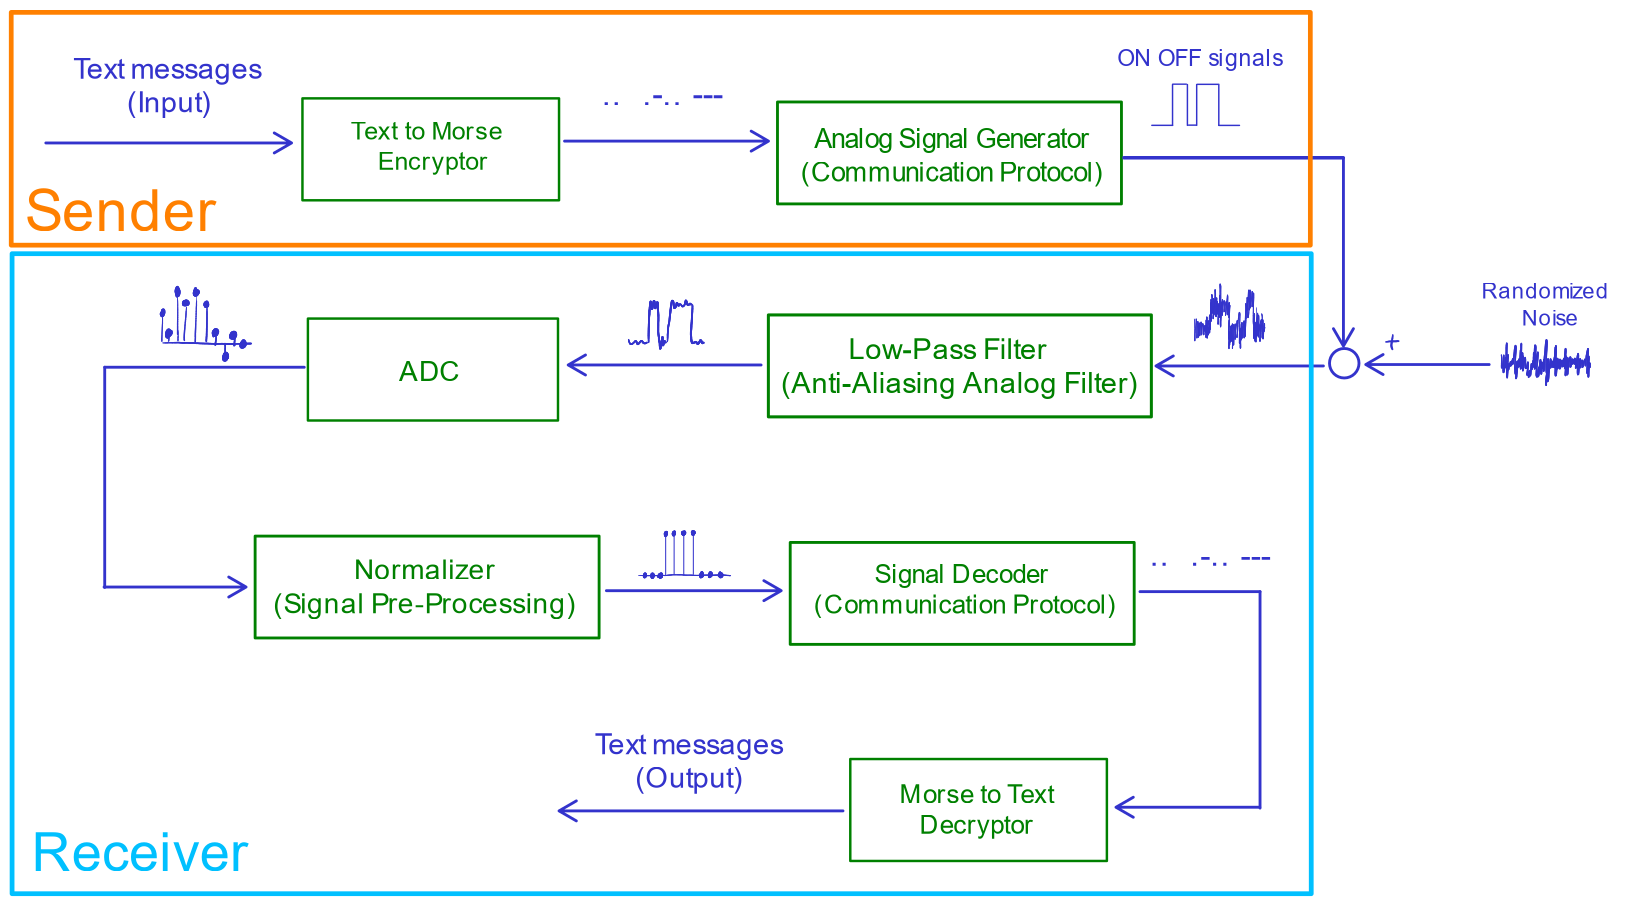

-----(This whole part about Morse code and Text conversion can be packed)
### Necessary Functions for Morse Code and Text Conversion

This Section includes the __"Morse  Encryptor/Decryptor"__ functions, please do not touch it!

##### Morse code dictionary
For a full list morse code characters see [here](https://morsecode.world/international/morse2.html).

In [30]:
# Define the morse code dictionary.
MORSE_CODE_DICT = { 'A':'.-', 'B':'-...',
                    'C':'-.-.', 'D':'-..', 'E':'.',
                    'F':'..-.', 'G':'--.', 'H':'....',
                    'I':'..', 'J':'.---', 'K':'-.-',
                    'L':'.-..', 'M':'--', 'N':'-.',
                    'O':'---', 'P':'.--.', 'Q':'--.-',
                    'R':'.-.', 'S':'...', 'T':'-',
                    'U':'..-', 'V':'...-', 'W':'.--',
                    'X':'-..-', 'Y':'-.--', 'Z':'--..',
                    '1':'.----', '2':'..---', '3':'...--',
                    '4':'....-', '5':'.....', '6':'-....',
                    '7':'--...', '8':'---..', '9':'----.',
                    '0':'-----', ', ':'--..--', '.':'.-.-.-',
                    '?':'..--..', '/':'-..-.', '-':'-....-',
                    '(':'-.--.', ')':'-.--.-','':''}

##### Text to Morse Encryptor (function)

In [31]:
# Function to encrypt the string according to the Morse code chart.
def encrypt(message: str) -> str:
    """
    Encrypts a given message using Morse code.

    Parameters:
    - ``message`` (str): The message to be encrypted.

    Returns:
    - ``cipher`` (str): The encrypted message in Morse code.
    """
    cipher = ''
    for letter in message:
        if letter != ' ':
            cipher += MORSE_CODE_DICT[letter] + ' '
        else:
            cipher += ' '

    return cipher

##### Morse to Text Decryptor (function)

In [32]:
# Function to decrypt the string from Morse to English.
def decrypt(message: str) -> str:
    """
    Decrypts a message encoded in Morse code.
    
    Parameters:
     - ``message`` (str): The Morse code message to be decrypted.
        
    Returns:
     - ``decipher`` (str): The decrypted message in English.
    """
    
    # Extra space added at the end to access the last morse code.
    message += ' '
    
    # Variables to keep track of the Morse code and the English translation.
    decipher = ''
    citext = ''
    for letter in message:
 
        # Checks for space.
        if (letter != ' '):
            # Counter to keep track of space.
            i = 0
 
            # Storing Morse code of a single character.
            citext += letter
 
        # In the case of space.
        else:
            # If i = 1 that indicates a new character.
            i += 1
 
            # If i = 2 that indicates a new word.
            if i == 2 :
                 # Adding space to separate words.
                decipher += ' '
            else:
                try:
                    # Accessing the keys using their values (reverse of encryption).
                    decipher += list(MORSE_CODE_DICT.keys())[list(MORSE_CODE_DICT.values()).index(citext)]
                    citext = ''
                except:
                    pass
 
    return decipher

## __Sender__

In this section, we simulate a message sender. Before everything, we need to define a __Communication(COM) Protocol__

### _Communication Protocol_ (define COM Frequency)

The __"Morse Communication(COM) Frequency"__ sets the minimum duration for the "ON" signal when simulating the analog signal. In simpler terms, it dictates the operational frequency of the __"Analog Signal Generator"__ and, consequently, establishes the data transfer rate.

In [33]:
# Morse communication Frequency in [Hz]. Feel free to change this value.
MORSE_COM_FREQ = 5

Then we define a standardized "ON" & "OFF" analog signal to represent the _Morse Code_


- ".": 1 Interval "ON" followed by 1 Interval "OFF"
- "-": 2 Interval "ON" followed by 1 Interval "OFF"
- " ": 2 Interval "OFF"

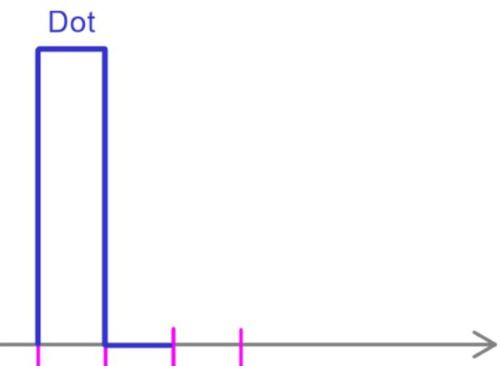

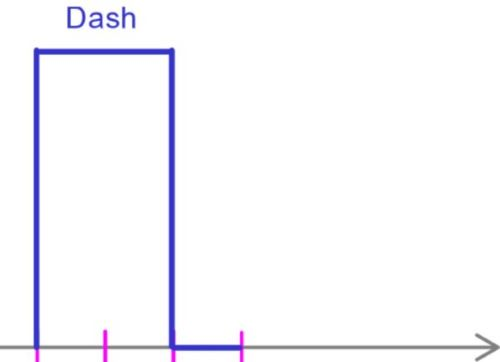

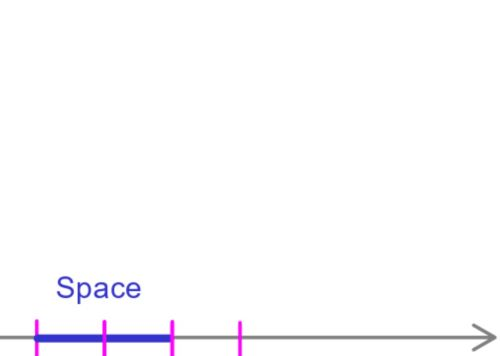

Since both the dot and the dash end in an "OFF" position and start in an "ON" position, any 2 wide space must contain a "Space". This allows us to improve data-transmission rates by shortening the length of "Space" to be 1.

Below are the __"Analog Signal Generator"__ & __"Signal Decoder"__ functions, please do not touch them!

-----(All the (function) here below can be packed)
#### Analog Signal Generator (function)

In [34]:
def code_to_signal(t_cont: np.array,                
                   morse_code: str,
                   morse_com_freq: float) -> np.array:
  """
  Standardized signal to represent the Morse Signal:

  ".": 1 ON & 1 OFF
  "-": 2 ON & 1 OFF
  " ": 2 OFF

  This Function that turns these into ON and OFF signals.

  Parameters: 
  - ``t_cont`` (np.array): Array of time values for the continuous signal.
  - ``morse_code`` (str): The Morse code message to be transmitted.
  - ``morse_com_freq`` (float): The frequency of the Morse code signal.
      
  Output: 
  - ``morse_signal`` (np.array): The Morse code signal.
  """
  
  # A calculation turns the frequency to the period in [s].
  # The period defines how long a "." is (represented in signal as on).
  period = 1/morse_com_freq
  
  # Generate an empty array matching the size of the continuous time array for signal data storage.
  morse_signal = np.zeros(t_cont.size)

  e = 0
  i = 0

  # Check if counter within both array.
  while ((e < len(morse_code)) and (i < t_cont.size - 1)):
    # If yes, read the current character in Morse code and determine what to write on the signal data storage.
    
    """
    ".": 1 ON & 1 OFF
    "-": 2 ON & 1 OFF
    " ": 2 OFF
    """
    
    if morse_code[e] == '.':

      on_end = t_cont[i] + period
      off_end = t_cont[i] + 2*period

    if morse_code[e] == "-":
      on_end = t_cont[i] + 2*period
      off_end = t_cont[i] + 3*period

    if morse_code[e] == " ":
      on_end = t_cont[i]
      off_end = t_cont[i] + 2*period

    # After determining how long and what to write, write the signal on the data array.
    while ((t_cont[i] < on_end) and (i < t_cont.size - 1)):
      # Write the ON state.
      morse_signal[i] = 1
      i = i + 1

    while ((t_cont[i] <= off_end) and (i < t_cont.size - 1)):
      # Write the OFF state.
      morse_signal[i] = 0
      i = i + 1

    e = e + 1
    
  return morse_signal

#### Signal Decoder (function)

In [35]:
def signal_to_code(t_dis: np.array,
                   dis_morse_signal: np.array,
                   morse_com_freq: float) -> str:
  """
  This function decodes signals back to Morse Code.

  Parameters:
  - ``t_dis`` (np.array): Discrete-Time Time Array.
  - ``dis_morse_signal`` (np.array): Discrete-Time Signal Value Array. Signal must be normalized to 1 and 0.
  - ``morse_com_freq`` (float): Morse Communication Frequency.

  Returns:
  - ``morse_code`` (str): Morse Code consisting of ".", "-", and " ".
  """

  # A calculation turns the frequency to the period in [s].
  # The period defines how long a "." is (represented in signal as on).
  period = 1/morse_com_freq
  
  i = 0
  p = 0
  state = 0
  hold_time = 0
  code = ""
  
  while i < len(t_dis)-1:
    
    while state == 0:
      # Check if the element index is still in the range of the data array.
      # Check if the state remains unchanged, hence signal is smaller than 0.8.
      # Check if the OFF is being held for too long, might mean that the message has ended.
      while i < len(t_dis)-1 and dis_morse_signal[i] < 0.8 and hold_time < 20*period:
        # Move to the next element.
        i += 1
        hold_time = t_dis[i] - t_dis[p]
        
      if i >= len(t_dis)-1:
        # This condition indicates wether the index is over the total elements, in which case the function should be terminated.
        return code
      
      if hold_time >= 10*period:
        # This condition indicates the message ends.
        code += "  "
        return code
      
      # Otherwise it indicates a state change from OFF to ON, and the message continues.
      if hold_time >= 0.6*period:
        if hold_time >= 2.5*period:
          if hold_time >= 4.2*period:
            code += "  "
          else:
            code += " "
      # Otherwise it was just a break to start another character.
      
      # Change the state to ON.
      state = 1
      # Refresh the timer.
      p = i
      
    while state == 1:
      # Check if the element index is still in the range of the data array.
      # Check if the state remains unchanged, hence signal is higher than 0.8.
      # Check if the ON is being held for too long, might mean that the message has an error.
      while i < len(t_dis)-1 and dis_morse_signal[i] >= 0.8 and hold_time < 20*period:
        # Move to the next element.
        i += 1
        hold_time = t_dis[i] - t_dis[p]
      
      if i >= len(t_dis)-1:
        # This condition indicates the index is over the total elements, in which case the function should be terminated.
        return code
      
      if hold_time >= 20*period:
        # This condition indicates the message ends.
        code += "  "
        return code
      
      # Otherwise it indicates a state change from ON to OFF, and the message continues.
      if hold_time >= 0.6*period:
        # If ON time is longer than 1.8, it's a "-".
        if hold_time >= 1.6*period:
          code += "-"
        else:
          code += "."
      
      # Change the state to OFF.
      state = 0
      # Refresh the timer.
      p = i
    
  return code
  

-----(Don't pack this part of "creating continues Time Array...")
#### Creating a Continues-Time Time Array for Plotting

Do not touch it! 

In [36]:
""" 
We need a Time Array for us to keep track of the continuous analog signals.
But in the computational world, there's no true continuous time domain.
Everything is eventually in discrete time.

So here we create a 1D-Array for continuous time plotting, "Continues-Time Time Array"
this array will be very big and the time steps between each value will be so small,
smaller than our Morse communication period, so it can be seen as "continues".
"""

# Do not change the code below if you don't know what you are doing!
# Plotting START & END time in [s].
T_CONT_START = 0
T_CONT_END = 15


# Continues Time domain plotting Data storage Frequency in [Hz].
T_CONT_FREQ = 200
# A calculation turns the frequency to the period in [s].
T_CONT_PERIOD = 1/T_CONT_FREQ


# Get the total time.
Time_span = T_CONT_END - T_CONT_START
# Calculate how many elements should be in the Continues Time plotting Data Array and force it to be int.
t_steps = int (Time_span*T_CONT_FREQ)


# Generate an Array for continuous time.
T_CONT = np.linspace(T_CONT_START,T_CONT_END,t_steps + 1)

### __Text Message (Input)__ (type your message in the code)

In [37]:
# Message to send.
TEXT_MESSAGE = "I love CS 2"

### __Text to Morse Encryptor__

We feed the Text Message into the __"Text to Morse Encryptor"__ and turn it into _Morse Code_.

In [38]:
# Morse Code Encryption.
MORSE_CODE_TO_SEND = encrypt(TEXT_MESSAGE.upper())
print(MORSE_CODE_TO_SEND)

..  .-.. --- ...- .  -.-. ...  ..--- 


### __Analog Signal Generator__

We feed the _Morse Code_ into the __"Analog Signal Generator"__. Following the _Communication Protocol_, it generates our _Analog Signal_ to be transmitted.

COM Protocol:
".": 1 Period ON & 1 OFF
"-": 2 ON & 1 OFF
" ": 2 OFF 

MORSE_CODE_TO_SEND:
..  .-.. --- ...- .  -.-. ...  ..--- 


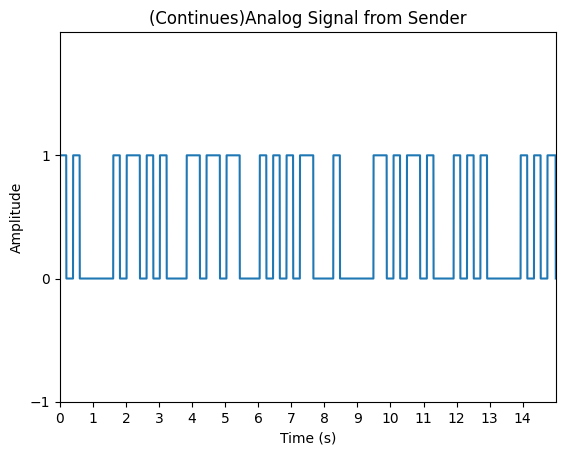

In [39]:
# We defined the code to signal function above in the communication protocol section.
# Morse code to Analog signals
CONT_Morse_Signal_Send = code_to_signal(T_CONT,MORSE_CODE_TO_SEND,MORSE_COM_FREQ)


print("COM Protocol:")
print('".": 1 Period ON & 1 OFF')
print('"-": 2 ON & 1 OFF')
print('" ": 2 OFF','\n')

print("MORSE_CODE_TO_SEND:")
print(MORSE_CODE_TO_SEND)


# Plot out the continuous signal
fig, ax = plt.subplots()
ax.plot(T_CONT,CONT_Morse_Signal_Send)
ax.set_title("(Continues)Analog Signal from Sender")
ax.set(xlim=(T_CONT_START,T_CONT_END),
       xticks=np.arange(T_CONT_START, T_CONT_END),
       ylim=(-0.5, 2),
       yticks=np.arange(-1, 2))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## __Transmission and introduction of noise__

In this section, we generate a randomized signal as _Noise_ and add it with the clean analog signal that leaves the __"Sender"__ to better simulate a real noisy world.

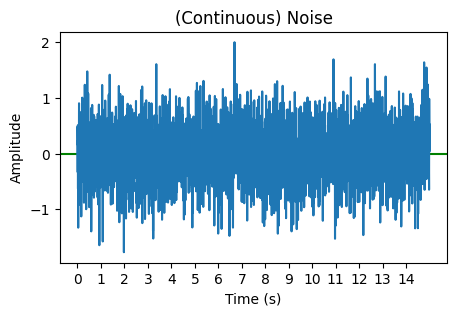

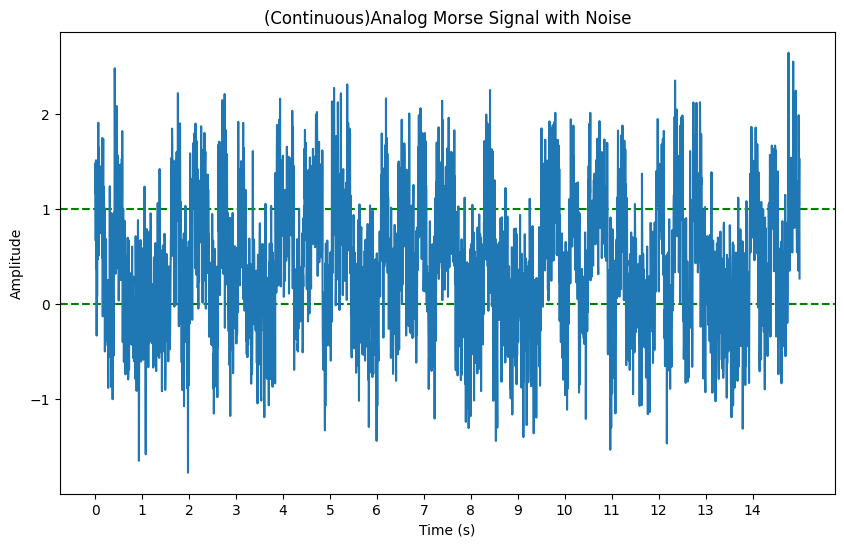

In [40]:
# Using np.random to generate random value as Noise
Randomized_Noise = 0.5 * np.random.normal(size=len(T_CONT))


# Add the Noise with the clean Signal from Sender
CONT_Morse_Signal_w_noise = CONT_Morse_Signal_Send + Randomized_Noise


# Visualize the Noise signal
plot_noise_signal(T_CONT,Randomized_Noise,T_CONT_START,T_CONT_END)


# Plot out the continuous signal with noise introduced
plt.figure(figsize=(10, 6))
plt.title("(Continuous)Analog Morse Signal with Noise")
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.plot(T_CONT, CONT_Morse_Signal_w_noise)
# Uncomment the line below to see the original signal without noise
# plt.plot(T_CONT, CONT_Morse_Signal_Send, color='y')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## __Receiver__

In this section, we simulate a message receiver. From picking up the analog signal to processing it and finally giving out a message output.

### __Low-Pass Filter (Anti-Aliasing Analog filter)__
When the signal is picked up by the Receiver, it first has to go through a Low-Pass Filter to clean up some of the high-frequency noise.

-----(This (function) can be packed as well)
#### _Low-Pass Filter (function)_
We define a low-pass filter and try to filter out some high-frequency random noise mixed in the signal before we sample it. To do this we used a scipy package filter named "butter"

In [69]:
def butter_lowpass_filter(data: np.array,
                          cutoff_frequency: float,
                          sampling_frequency: float,
                          order: int) -> np.array:
    """
    Apply a low-pass Butterworth filter to the input signal data.
    
    Parameters:
    - ``data`` (np.array): 1D array of signal values.
    - ``cutoff_frequency`` (float): Cutoff frequency of the filter.
    - ``sampling_frequency`` (float): Sampling frequency of the data.
    - ``order`` (int): Order of the low-pass transfer function.
    
    Returns:
    - ``filtered_data`` (np.array): 1D array of filtered signal values.
    """
    nyquist = 0.5 * sampling_frequency
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter to the signal.
    filtered_data = lfilter(b, a, data)
    return filtered_data


#### __Low-Pass Filter__ (define cutoff frequency)

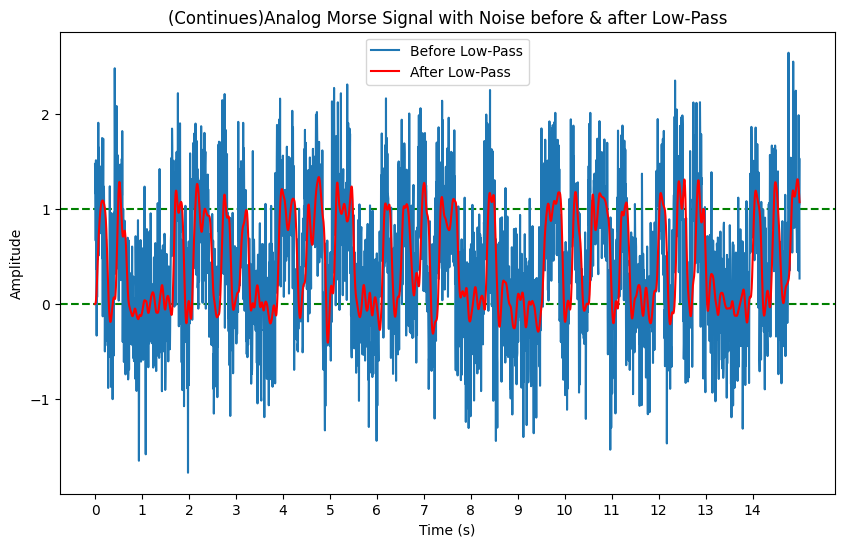

In [42]:
# Set the cutoff frequency for the low-pass filter. Adjust this based on your requirements.
CUTOFF_FREQ = 7  


# Apply the low-pass filter.
after_low_pass = butter_lowpass_filter(CONT_Morse_Signal_w_noise, 
                                       CUTOFF_FREQ, 
                                       T_CONT_FREQ, 
                                       4)

# Plot out the continuous signal with noise introduced and compare it with the signal that is after low-Pass filter.
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=1, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal with Noise before & after Low-Pass")
plt.plot(T_CONT, CONT_Morse_Signal_w_noise, label='Before Low-Pass')
plt.plot(T_CONT, after_low_pass, 'r' ,label='After Low-Pass')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

We can see the improvement if we tune the Low-Pass Filter right. From here, we can recognize roughly the "Dot" and "Dash", which were represented by long and short signals.  

### __Analog to Digital Converter (ADC)__
After we filter out some noise signals, they can then be sampled by the ADC and turn the continuous signal into discrete signal data.

-----(This ADC(Function) can be packed)
#### _ADC (function)_
This Section defines our ADC function. Notice that the output Discrete-Time 1D-Array is typically smaller than the input Continues-Time Arrays. 

In [43]:
def analog_digital_converter(t_cont: np.array,
                             cont_signal: np.array,
                             freq: float,
                             t_or_s: str) -> np.array:
    """
    This function selectively picks the data points from the continuous data array to simulate signal sampling.
    
    Parameters:
    - ``t_cont`` (np.array): Continues-Time Time Array.
    - ``cont_signal`` (np.array): Continues-Time Signal Value Array.
    - ``freq`` (float): ADC Sampling Frequency.
    - ``t_or_s`` (str): Array generator selector. 't' to generate a Discrete-Time Time Array, 's' to generate a Discrete-Time Signal Value Array.
    
    Returns:
    - ``t_dis`` OR ``dis_signal`` (np.array): Discrete-Time Time Array or Discrete-Time Signal Value Array, depending on the value of t_or_s.
    """
    
    # Converting the Sampling frequency to the sampling period.
    period = 1/freq
 
    # Initialize an empty array to store the time data for discrete time.
    t_dis = np.zeros(t_cont.size)
    dis_signal = np.zeros(t_cont.size)
 
    i = 0
    p = 0
    e = 0
 
    # Check if the element index is still in the range of the time array.
    while i < len(t_cont)-1:
        
        # Collect data from continuous time and write it to the sensor data array.
        t_dis[e] = t_cont[i]
        dis_signal[e] = cont_signal[i]
        
        # Move to the next element in the sensor data.
        e += 1
        
        # Keep skipping the time till the next time to be sampled by the sensor.
        # While checking if the element is still in range.
        while (t_cont[i] < t_cont[p] + period) and (i < len(t_cont)-1):
            i += 1
        # We skipped a period in continuous time, now it is time to collect data.
        p = i
    
    # If dis_time wanted, return dis_time array.
    if t_or_s == "t":
        return t_dis   
    
    # If dis_signal wanted, return dis_signal array
    if t_or_s == "s":
        return dis_signal
 
    return None
    

#### __ADC__ (define sampling frequency)

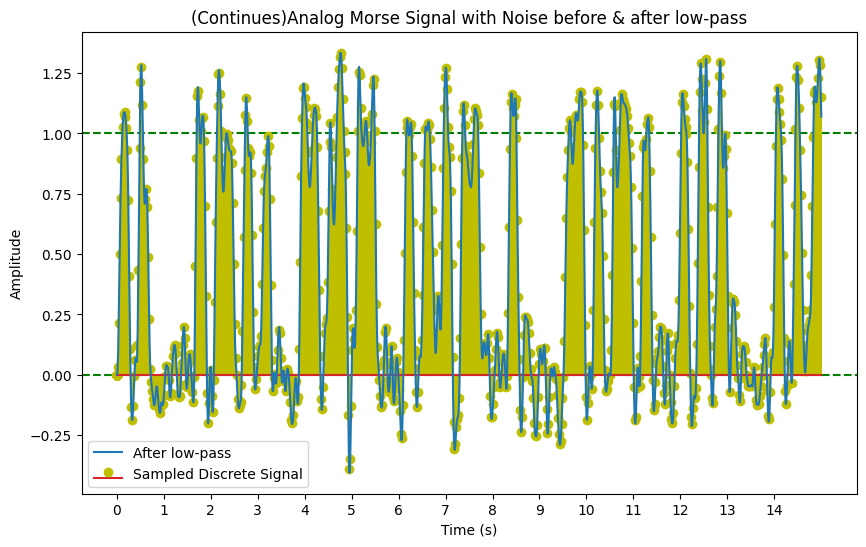

In [44]:
# Define the sampling frequency of your Receiver (Analog to Digital converter) in [Hz].
SAMPLING_FREQ = 50


# First generate a Discrete-Time Time Array: 1D-Array.
T_DIS_Morse = analog_digital_converter(T_CONT,
                                       after_low_pass,
                                       SAMPLING_FREQ,
                                       "t")

# Then generate a Discrete-Time Signal value Array: 1D-Array.
DIS_Morse_Signal_w_N_Raw = analog_digital_converter(T_CONT,
                                                    after_low_pass,
                                                    SAMPLING_FREQ,
                                                    "s")


# Plot out the continuous signal with noise introduced.
plt.figure(figsize=(10, 6))
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal with Noise before & after low-pass")
plt.stem(T_DIS_Morse, DIS_Morse_Signal_w_N_Raw, 'y' ,label='Sampled Discrete Signal')
plt.plot(T_CONT, after_low_pass, label='After low-pass')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

_"Continues-Time Signal"_ is represented by the continuous line, while sampled signal, _"Discrete-Time Signal"_ is represented by the Points.

###  __Normalizer__ <a id="normalizer"></a>

After we sampled the analog signal, it is now discrete values instead of continuous. Noticed that the values are anywhere between "-1" to "2". Before we start to decode the discrete signal to _Morse Code_, we need to normalize it to "1" and "0". So the decoder can have an easy time decoding the signal to _Morse Code_.

-----(This (Function) can be packed)
#### _Normalizer (function)_

In [45]:
def data_normalization_sol(data_raw: np.array,
                           min: float,
                           normalization: float,
                           idle: float) -> np.array:
    """
    Normalize the input data array to discrete values of 1 or 0.
    If the signal value is higher than or equal to the minimum threshold, it is normalized to the normalization value.
    If the signal value is lower than the minimum threshold, it is normalized to the idle value.
    
    Parameters:
    - ``data_raw`` (np.array): 1D array of raw data points.
    - ``min`` (float): Minimum threshold for normalization.
    - ``normalization`` (float): Value to normalize to when the signal value is higher than or equal to the minimum threshold.
    - ``idle`` (float): Value to normalize to when the signal value is lower than the minimum threshold.
    
    Returns:
    - ``data_norm`` (np.array): 1D array of filtered data points with the same size as the raw data array.
    """
    # Create an array to save the filtered data with the same size as the raw data array.
    data_norm = np.zeros(data_raw.size)
    
    # Check each value and normalize or set it to the idle value in the filtered data array.
    for i in range(data_raw.size - 1):
        if min <= data_raw[i]:
            data_norm[i] = normalization
        else:
            data_norm[i] = idle
        i += 1 
    return data_norm

#### __Normalizer__ (define Threshold)

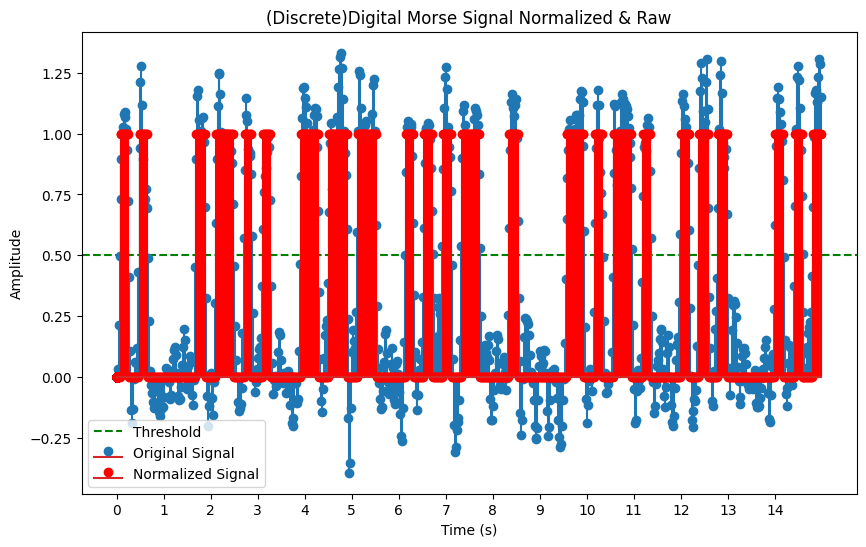

In [46]:
# Apply the Normalizer to the raw discrete signal data.
DIS_Morse_Signal_w_N_Normalized = data_normalization_sol(DIS_Morse_Signal_w_N_Raw,
                                                         0.6,
                                                         1,
                                                         0)


# Plot out the normalized discrete signal data and compare it with raw data.
plt.figure(figsize=(10, 6))
plt.axhline(y=0.5, color='g', linestyle='--', label= 'Threshold')
plt.title("(Discrete)Digital Morse Signal Normalized & Raw")
plt.stem(T_DIS_Morse, DIS_Morse_Signal_w_N_Raw, label='Original Signal')
plt.stem(T_DIS_Morse, DIS_Morse_Signal_w_N_Normalized, 'r' ,label='Normalized Signal')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### __Signal Decoder__

In [47]:
# This feed the normalized signal to the signal decoder.
CODE_Received_I = signal_to_code(T_DIS_Morse,DIS_Morse_Signal_w_N_Normalized,MORSE_COM_FREQ)

# This bypass the normalization and directly feed to the signal decoder.
CODE_Received_II = signal_to_code(T_DIS_Morse,DIS_Morse_Signal_w_N_Raw,MORSE_COM_FREQ)


# Uncomment the following two lines to see the original message that sent by the Sender.
#print("Code sent:")
#print(MORSE_CODE_TO_SEND)


print("Received signal filtered decrypted to Code:")
print(CODE_Received_I)


# Uncomment the following two lines to see the decrypted message directly
#print("Code to message:")
#print(decrypt(CODE_Received_I))

# Uncomment the following two lines to see the decrypted code bypassing normalizer
#print("Received signal without normalization decrypted to Code:")
#print(CODE_Received_II)


#The following line sometimes can cause problems.
#Uncomment it to see the result when signals are not normalized and 
#directly feed into the decryption
#"""
#print("Code to message:")
#print(decrypt(CODE_Received_II))

Received signal filtered decrypted to Code:
..  .-.. --- ...- .  -.-. ...  ..


### __Morse To Text Decryptor__

In [48]:
#print("Received signal filtered decrypted to Code:")
#print(CODE_Received_I)
print("TEXT MESSAGE (Output):")
print(decrypt(CODE_Received_I))

TEXT MESSAGE (Output):
I LOVE CS I


(It's an Easter egg, the input is I LOVE CS 2, But it came out as I LOVE CS I stating a joke here. xD But think about, why does it happen?)

# __Exercise__

## Nyquist Frequency

Validation of the __"Nyquist Frequency"__ and finding the minimum Sampling frequency that guarantees a correct message decryption.

In [49]:
# You can define these values and play around with them.

# COM Protocol.
# Morse communication Frequency in [Hz] 
# default (5)
Ex_MORSE_COM_FREQ = 5


# Message to send.
# default ("I CAN DO CS II")
Ex_MESSAGE = "I CAN DO CS II"

#### Perfect condition

Which minimum sampling frequency do you observe? When there's no noise in the received signal?

In [50]:
# ADC Sampling Frequency in [Hz]
# default (10)
Ex_SAMPLING_FREQ_PERF = 10


# Feed the Text input to Encryptor and then generate it to the Analog Signal.
# Generate the Morse Signal in continues-time (CONT).
Ex_CONT_Morse_Signal_Send = code_to_signal(T_CONT, encrypt(Ex_MESSAGE), Ex_MORSE_COM_FREQ)



# Direct feed to ADC, since there is no noise, it doesn't matter.
# Sampled by ADC.
# Generate Time Data.
Ex_T_DIS_Morse = analog_digital_converter(T_CONT,
                                          Ex_CONT_Morse_Signal_Send,
                                          Ex_SAMPLING_FREQ_PERF,
                                          "t")

# Sample the Signal.
Ex_DIS_Morse_Signal_Raw = analog_digital_converter(T_CONT,
                                                   Ex_CONT_Morse_Signal_Send,
                                                   Ex_SAMPLING_FREQ_PERF,
                                                   "s")


# Decode signal to Morse.
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Raw,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message.
print("Message received:")
print(decrypt(Ex_CODE_Received))

Message received:
I CAN DO CI


#### Plotting

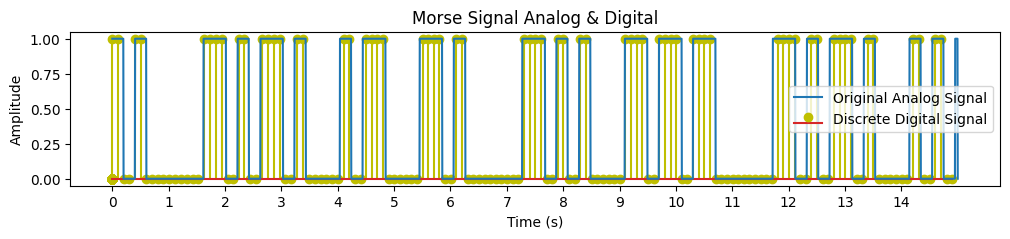

In [51]:
plt.figure(figsize=(12, 2))
plt.title("Morse Signal Analog & Digital")
plt.stem(Ex_T_DIS_Morse, Ex_DIS_Morse_Signal_Raw, 'y', label='Discrete Digital Signal')
plt.plot(T_CONT, Ex_CONT_Morse_Signal_Send, label='Original Analog Signal')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Noise Condition (__Exercise in this Section__)

Now we introduce a random noise to the signal.

##### Without any pre-processing

In [52]:
# ADC Sampling Frequency in [Hz].
# default (15)
Ex_SAMPLING_FREQ_NOISE = 15

# Low-Pass Cutoff Frequency in [Hz].
# default (10)
# This should be higher than the Morse-COM Frequency.
Ex_LOW_PASS_CUTOFF_FREQ = 10


# Feed the Text input to Encryptor and then generate it to the Analog Signal.
# Generate the Morse Signal in continues-time (CONT) with random noise.
Ex_CONT_Morse_Signal_w_noise = code_to_signal(T_CONT,
                                              encrypt(Ex_MESSAGE),
                                              Ex_MORSE_COM_FREQ)+ 0.5 * np.random.normal(size=len(T_CONT))


# Feed through anti-aliasing(low-pass) filter before feed into ADC.
Ex_CONT_Morse_Signal_w_noise_af_low_pass = butter_lowpass_filter(Ex_CONT_Morse_Signal_w_noise,
                                                                 Ex_LOW_PASS_CUTOFF_FREQ,
                                                                 T_CONT_FREQ,
                                                                 3)


# Sampled by ADC.
# Generate Time Data.
Ex_T_DIS_Morse = analog_digital_converter(T_CONT,
                                          Ex_CONT_Morse_Signal_w_noise_af_low_pass,
                                          Ex_SAMPLING_FREQ_NOISE,
                                          "t")

# Sample the Signal.
Ex_DIS_Morse_Signal_Raw = analog_digital_converter(T_CONT,
                                                   Ex_CONT_Morse_Signal_w_noise_af_low_pass,
                                                   Ex_SAMPLING_FREQ_NOISE,
                                                   "s")


# Decode signal to Morse.
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Raw,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message. (Without Pre-Processing)
"""""
Notice:
The following lines can cause problems due to noise feeding into the decryption.
Decrypt Morse to message. (Without Post-Processing) under huge noise conditions
is impossible.
Therefore, the following lines are commented.

Instead, we compare the Morse code between sent and received.
"""

#print("Message received:")
#print(decrypt(Ex_CODE_Received))

print("Code sent:")
print(encrypt(Ex_MESSAGE))

print("Code received:")
print(Ex_CODE_Received)


Code sent:
..  -.-. .- -.  -.. ---  -.-. ...  .. .. 
Code received:
..  .-. .. ..  ... ..-  ...-. .


We observe that as soon as there's a noise in the signal, our decryption struggles to get the correct message. Because the __Signal Decoder__ using "1" and "0" and the period in between to decode the signal back to _Morse Code_, but our signal here contains values between 1 and 0 even after the __Low-Pass Filter__.
Here we see the importance of a filter and signal normalization for post-computation (decryption). 

#### Plotting

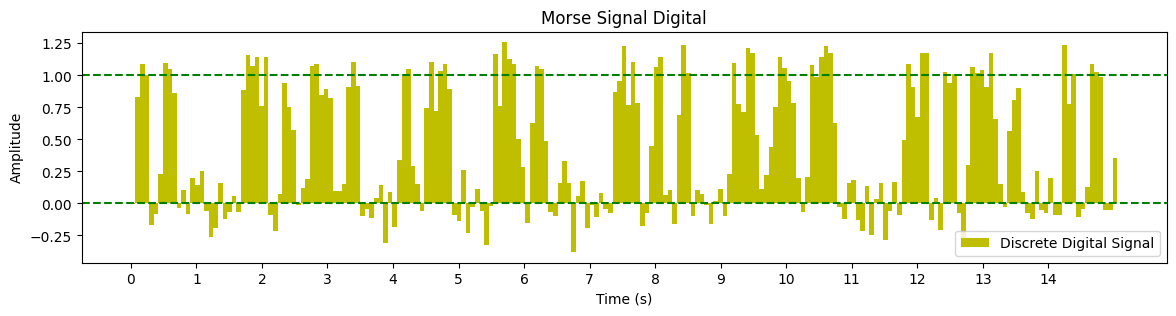

In [53]:
plt.figure(figsize=(14, 3))
plt.title("Morse Signal Digital")
plt.axhline(y=1, color='g', linestyle='--')
plt.axhline(y=0, color='g', linestyle='--')

# Uncomment the following line to see a different plotting style for discrete signal
#plt.stem(Ex_T_DIS_Morse, Ex_DIS_Morse_Signal_Raw, 'y', label='Discrete Digital Signal')

# Uncomment the following line to see the signal in continues-time domain.
#plt.plot(T_CONT, Ex_CONT_Morse_Signal_w_noise_af_low_pass,'c', label='Analog Signal')

width_ksczeiv = Ex_T_DIS_Morse[1] - Ex_T_DIS_Morse[0]
plt.bar(Ex_T_DIS_Morse, Ex_DIS_Morse_Signal_Raw, align='edge', width=width_ksczeiv, color='y', linewidth=1, label='Discrete Digital Signal')

plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

##### __Your code here (Exercise)__ 

Now implement a function to normalize the data. If you need help, feel free to look at the function above. In __Case Study__ the section: __Normalizer__

In [54]:
def ex_data_normalization(data_raw: np.array,
                          min: float,
                          normalization: float,
                          idle: float) -> np.array:
    """
    This function normalizes the input data by setting values below the minimum threshold to the idle value,
    and values above the threshold to the normalization value.
    
    Args:
     - ``data_raw`` (np.array): 1-D array of raw data.
     - ``min`` (float): Minimum threshold.
     - ``normalization`` (float): Value to normalize to after reaching the threshold.
     - ``idle`` (float): Value to set when data is lower than the threshold.
        
    Returns:
     - ``np.array``: 1-D array of filtered data, with the same size as the raw data array.
    """
    # Create an array to save the filtered data with the same size as the raw data array.
    data_norm = np.zeros(data_raw.size)
    
    # Check each value and normalize or set it to idle value in the filtered data array.
    # Your code here ---------------------------------------------------------------------------

    
    return data_norm

# Your code here ---------------------------------------------------------------------------


##### With post-processing (__Code Modification needed__)

The first function is the solution. "Ex_DIS_Morse_Signal_Normalized = data_normalization_sol(Ex_DIS_Morse_Signal_Raw,0.5,1,0)". You need to implement your function below in able to see your test result.

In [55]:
# Run the Normalized function.
# Fine-tune the threshold to make sure a correct Message decryption.
Ex_DIS_Morse_Signal_Normalized = data_normalization_sol(Ex_DIS_Morse_Signal_Raw,0.5,1,0)



"""
 Uncomment the lines below and implement your function. 
 Once you implement the function, it overwrite the solution value and
 it plot out your results.
"""

# Your Code here-----------------------------------------------------------------------------------
# Ex_DIS_Morse_Signal_Normalized = ex_data_normalization().



# Your Code here-----------------------------------------------------------------------------------



# Decode signal to Morse.
Ex_CODE_Received = signal_to_code(Ex_T_DIS_Morse,
                                  Ex_DIS_Morse_Signal_Normalized,
                                  Ex_MORSE_COM_FREQ)


# Decrypt Morse to message.
print("Message received:")
print(decrypt(Ex_CODE_Received))

Message received:
I CAN DO CI


## Data transfer rate

We noticed that in the Nyquist Frequency section, using default values:


Morse communication Frequency: 5 [Hz]


Nyquist Frequency: 10 [Hz]


Message to send: "I CAN DO CS II"


ADC Sampling Frequency 20 [Hz]


We can not send the full message.


Think about how can you increase the data transfer rate.

### Increase operating and sampling Frequency (__Exercise in this Section__)

#### Adjust the Morse-COM frequency and define a message to send
Adjust the __"Morse-communication protocol frequency"__ (Ex_MORSE_COM_FREQ_II) to a higher value. You can imagine that: instead of speaking a sentence slowly, now we speak it fast so we can finish speaking the whole sentence in a shorter time. Thus in the same given time as before, we can pass on more information.

In [56]:
# You can define these values and play around with them.

# COM Protocol
# Morse communication Frequency in [Hz]
# Before (5)
# default (20)
Ex_MORSE_COM_FREQ_II = 20


# Message to send
Ex_MESSAGE_II = "I CAN DO CS II and beyond"

#### Simulation Run & Results (__Exercise in this Section__)
Now we run through the steps:


1. Generate an analog signal with (code_to_signal).


2. And use our predefined ADC (analog_digital_converter) to sample the signal.


3. Decode that sampled signal to Morse code (signal_to_code).


4. And finally, decrypt the Code to the Message (decrypt(...)).

In [57]:
# ADC Sampling Frequency in [Hz]
# Before (20)
# default (200)
Ex_SAMPLING_FREQ_II = 200


# Feed the Text input to Encryptor and then generate it to the Analog Signal
# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send_II = code_to_signal(T_CONT, encrypt(Ex_MESSAGE_II.upper()), Ex_MORSE_COM_FREQ_II)


# Direct feed to ADC, since there is no noise, it doesn't matter
# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse_II = analog_digital_converter(T_CONT,
                                          Ex_CONT_Morse_Signal_Send_II,
                                          Ex_SAMPLING_FREQ_II,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw_II = analog_digital_converter(T_CONT,
                                                   Ex_CONT_Morse_Signal_Send_II,
                                                   Ex_SAMPLING_FREQ_II,
                                                   "s")


# Decode signal to Morse
Ex_CODE_Received_II = signal_to_code(Ex_T_DIS_Morse_II,
                                  Ex_DIS_Morse_Signal_Raw_II,
                                  Ex_MORSE_COM_FREQ_II)


# Decrypt Morse to message.
print("Code sent:")
print(encrypt(Ex_MESSAGE_II.upper()))
print("Message received:")
print(Ex_CODE_Received_II)
print(decrypt(Ex_CODE_Received_II))

Code sent:
..  -.-. .- -.  -.. ---  -.-. ...  .. ..  .- -. -..  -... . -.-- --- -. -.. 
Message received:
..  -.-. .- -.  -.. ---  -.-. ...  .. ..  .- -. -..  -... . -.-- --- -. -..  
I CAN DO CS II AND BEYOND 


Now compare with the result before in part "Nyquist Frequency". There we receive a sentence of "I CAN DO C" in 15 [s]. While here, after we increase the Morse-COM protocol frequency, we can receive a full sentence of "I CAN DO CS II AND BEYOND" in the same 15 [s].

##### __Your code here (Exercise)__
Study the __plotting function__ we used before, explore the possibility of the "matplotlib" package (https://matplotlib.org/)

And plot out the result (Ex_DIS_Morse_Signal_Raw_II) signals nicely.

In [58]:
# Your code here---------------------------------------------------------------------------------



# Your code here---------------------------------------------------------------------------------

#### Solution

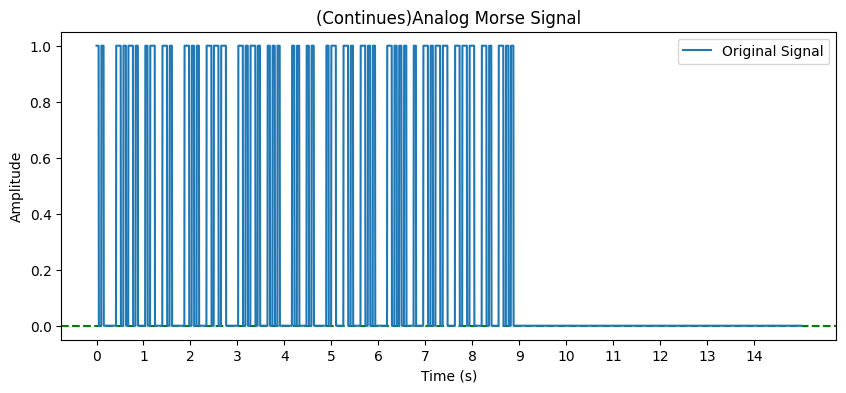

In [59]:
plt.figure(figsize=(10, 4))
plt.axhline(y=0, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal")
plt.plot(T_CONT, Ex_CONT_Morse_Signal_Send_II, label='Original Signal')
plt.xticks(np.arange(T_CONT_START, T_CONT_END))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Conclusion: Here we see that by increasing the COM frequency, we can send the whole message and even not exceed the 15 [s] time limit.

### Limitation (__Exercise in this Section__)
Why can't we just keep increasing the Morse-COM protocol frequency to the extreme to pass massive data volume?

What could be the potential limitations? And why Fiber-Optic is faster than Ethernet cable?

Here in this section, we gonna see why.

#### Redefine the _Morse-COM Protocol_ Frequency
Here we push the frequency even higher to observe high frequency behavior.

In [60]:
# You can define these values and play around with them.

# Morse communication Frequency in [Hz]
# Before (20)
# default (100000)
Ex_MORSE_COM_FREQ_H = 100000


# Message to send
Ex_MESSAGE_H = "I CAN DO CS II and beyond"

#### Redefine the plotting Span
To observe the high-frequency behavior, we have to zoom in in time. Here we redefine our plotting span to match the purpose. Change the plotting time from 0 to 1 [s]. While increasing the data plotting resolution to 100 [kHz]. Higher the resolution while also increasing the frequency.

In [61]:
# Do not change the code below if you don't know what you are doing!
# Plotting START & END time in [s]
T_CONT_START_H = 0
T_CONT_END_H = 0.0001


# Continues Time domain plotting Data storage Frequency in [Hz]
# default (200000000)
T_CONT_FREQ_H = 200000000
# A calculation turns the frequency to the period in [s]
T_COUNT_PERIOD_H = 1/T_CONT_FREQ_H


# Get the total time
Time_span_H = T_CONT_END_H - T_CONT_START_H
# Calculate how many elements should be in the Continues Time plotting Data Array
# And force it to be int.
t_steps_h = int (Time_span_H*T_CONT_FREQ_H)


# Generate an Array for continuous time
T_CONT_H = np.linspace(T_CONT_START_H,T_CONT_END_H,t_steps_h + 1)

#### Copper wire model
Here we use a Low-Pass filter from before as a model of a copper wire. Documentation of this Low-Pass Filter can be found on:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html 

In [62]:
def butter_lowpass_filter_H(data: np.array,
                            cutoff_frequency: float,
                            sampling_frequency: float,
                            order: int) -> np.array:
    """
    This function applies a low-pass filter to the input data using a Butterworth filter. It is meant to simulate the parastic effect of the wire.
    
    Args:
     - ``data`` (np.array): 1-D array of input data.
     - ``cutoff_frequency`` (float): Cutoff frequency of the filter in Hz.
     - ``sampling_frequency`` (float): Sampling frequency of the data in Hz.
     - ``order`` (int): Order of the filter.
        
    Returns:
     - ``y`` np.array: 1-D array of filtered data, with the same size as the input data array.
    """
    nyquist = 0.5 * sampling_frequency
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

#### Simulation Run & Results (__Exercise in this Section__)

In [63]:
# ADC Sampling Frequency in [Hz]
# Before (200)
# default (1000000)
Ex_SAMPLING_FREQ_H = 1000000


# Feed the Text input to Encryptor and then generate it to the Analog Signal
# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send_H = code_to_signal(T_CONT_H,
                                             encrypt(Ex_MESSAGE_H.upper()),
                                             Ex_MORSE_COM_FREQ_H)


# Apply the copper wire as a low-pass filter with a cutoff frequency in [Hz]
# default(100000)
CUTOFF_FREQ_H = 100000
after_copper_wire = butter_lowpass_filter_H(Ex_CONT_Morse_Signal_Send_H,
                                            CUTOFF_FREQ_H,
                                            T_CONT_FREQ_H,
                                            2)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse_H = analog_digital_converter(T_CONT_H,
                                          after_copper_wire,
                                          Ex_SAMPLING_FREQ_H,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw_H = analog_digital_converter(T_CONT_H,
                                                   after_copper_wire,
                                                   Ex_SAMPLING_FREQ_H,
                                                   "s")

##### __Your code here (Exercise)__
Study the plotting function we used before, explore the possibility of the "matplotlib" package (https://matplotlib.org/). And plot out the result signal (after_copper_wire) nicely. If you have difficulties doing so, you may have a look at the solution.

In [64]:
# Your code here---------------------------------------------------------------------------------



# Your code here---------------------------------------------------------------------------------

#### Solution

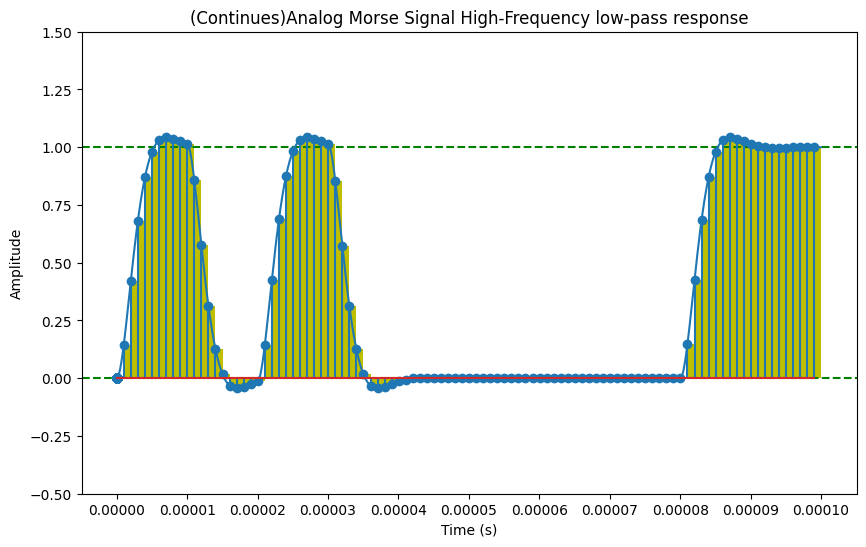

In [65]:
plt.figure(figsize=(10, 6))
plt.axhline(y=0, color='g', linestyle='--')
plt.axhline(y=1, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal High-Frequency low-pass response")
plt.plot(T_CONT_H, after_copper_wire)
plt.stem(Ex_T_DIS_Morse_H,Ex_DIS_Morse_Signal_Raw_H)

# Two lines below are simulating how 0-order-hold would look like
width_uezhc = Ex_T_DIS_Morse_H[1] - Ex_T_DIS_Morse_H[0]
plt.bar(Ex_T_DIS_Morse_H, Ex_DIS_Morse_Signal_Raw_H, align='edge', width=width_uezhc, color='y', linewidth=1, label='Discrete Digital Signal')

plt.xticks(np.linspace(0, 0.0001, 11))
plt.ylim(-0.5,1.5)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

#### Repeat the simulation and raise the __Morse-COM Frequency__
Raise the COM-Frequency (Ex_MORSE_COM_FREQ_H) higher step by step.
e.g. 


300'000 


400'000


500'000


...


And plot out the data to see the effects of the low-pass wire on limiting our data transfer rate.

In [66]:
# Morse communication Frequency in [Hz]
# Before (100000)
# default (2*100000)
Ex_MORSE_COM_FREQ_H_II = 2*100000


# ADC Sampling Frequency in [Hz]
# Before (200)
# default (1000000)
Ex_SAMPLING_FREQ_H_II = 1000000



# Generate the Morse Signal in continues-time (CONT)
Ex_CONT_Morse_Signal_Send_H_II = code_to_signal(T_CONT_H, encrypt(Ex_MESSAGE_H.upper()), Ex_MORSE_COM_FREQ_H_II)

# Apply the copper wire as a low-pass filter with cutoff frequency in [Hz]
# default(100000)
CUTOFF_FREQ_H_II = 100000
after_copper_wire_II = butter_lowpass_filter_H(Ex_CONT_Morse_Signal_Send_H_II,CUTOFF_FREQ_H_II,T_CONT_FREQ_H,2)


# Sampled by ADC
# Generate Time Data
Ex_T_DIS_Morse_H_II = analog_digital_converter(T_CONT_H,
                                          after_copper_wire_II,
                                          Ex_SAMPLING_FREQ_H_II,
                                          "t")
# Sample the Signal
Ex_DIS_Morse_Signal_Raw_H_II = analog_digital_converter(T_CONT_H,
                                                   after_copper_wire_II,
                                                   Ex_SAMPLING_FREQ_H_II,
                                                   "s")


##### __Your code here (Exercise)__
And plot out the resulting signal (after_copper_wire) nicely and overlay the sampled signal(Ex_DIS_Morse_Signal_Raw_H) on top of the analog signal.

Pay attention to the array size. The analog signal data has a greater size compared with the sampled(discrete) signal.

If you have difficulties doing so, you may have a look at the solution.

In [67]:
# Your code here---------------------------------------------------------------------------------



# Your code here---------------------------------------------------------------------------------

#### Solution

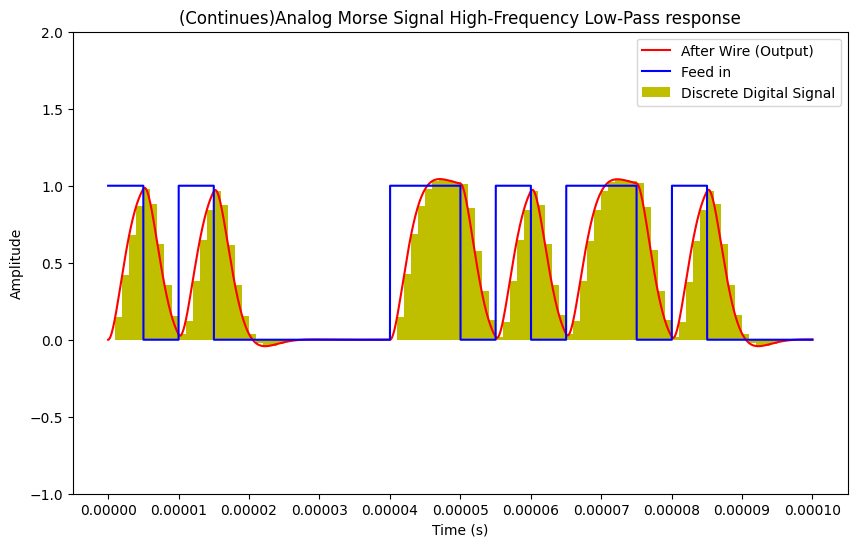

In [68]:
# Uncomment or comment some of the lines to see different style of plotting
plt.figure(figsize=(10, 6))
#plt.axhline(y=0, color='g', linestyle='--')
#plt.axhline(y=1, color='g', linestyle='--')
plt.title("(Continues)Analog Morse Signal High-Frequency Low-Pass response")
plt.plot(T_CONT_H, after_copper_wire_II, 'r' ,label="After Wire (Output)")
#plt.stem(Ex_T_DIS_Morse_H_II,Ex_DIS_Morse_Signal_Raw_H_II, 'g')
width_oivze = Ex_T_DIS_Morse_H_II[1] - Ex_T_DIS_Morse_H_II[0]
plt.bar(Ex_T_DIS_Morse_H_II, Ex_DIS_Morse_Signal_Raw_H_II, align='edge', width=width_oivze, color='y', linewidth=0, label='Discrete Digital Signal')
plt.plot(T_CONT_H, Ex_CONT_Morse_Signal_Send_H_II, 'b',label="Feed in")
plt.xticks(np.linspace(0, 0.0001, 11))
plt.ylim(-1,2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

#### Conclusion

When a signal passes through a copper wire used as a signal cable, its impedance starts to have effects on damping the signal when we use a high-frequency signal to transfer our data.

The longer the cable, the higher the impedance, and the stronger the damping effects on our signal. The transition between the state "ON" and "OFF" (1 and 0) becomes smoother, hence increasing the difficulty when we trying to normalize the signal and determine when it is an "ON" and when it is an "OFF".

At some point, it's impossible to identify the "ON" and "OFF" anymore. In comparison, a fiber optic has significantly lower damping effects on the light signals across longer distances. That also partially explains why with fiber optic we have a higher bandwidth and higher internet speed compared with coaxial cable internet.


Higher COM-Frequency requires in general better electronics equipment that can run on high frequency, which also sets a limit on our maximum operating frequency.

------------

# End of the Notebook
We hope you had a nice experience with these exercises and learnt something new. 